In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
from scipy import optimize
import re
import copy
import logging
import sys
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import StrMethodFormatter
sns.set()

# a little hacky, but works if you don't want to actually install the
# custom packages 
sys.path.append('../')
from uniswapv3_simulator.pool import Uniswapv3Pool
from uniswapv3_simulator.utils import *
from uniswapv3_simulator.math import tick_to_sqrt_price, sqrt_price_to_tick
from utils import amount_to_float

In [2]:
POOL = 'WETH-USDT-500'
NUMERAIRE_TOKEN = 1
MAX_DATE = '2022-01-28'
SAVE_FREQ = 'D'  # change to 'H' if you want hourly pool snapshots
SAVED_POOLS = f'./saved-pools/{POOL}.pickle'
SAVED_DAILY_RETURNS = f'./saved-daily-returns/{POOL}.pickle'
SAVED_WEEKLY_RETURNS = f'./saved-weekly-returns/{POOL}.pickle'

timestamp = datetime.now().strftime('%y%m%d%H%M%S')
logging.basicConfig(level=logging.INFO,
                    filename=f'./logs/{POOL}_{timestamp}.log')
logging.getLogger('uniswap-v3').setLevel(logging.INFO)
logging.getLogger('uniswap-v3.utils').setLevel(logging.DEBUG)

In [3]:
data = pd.read_pickle('../data/pool_data_clean.pickle')
swaps = data[POOL]['swaps']
liquidity = data[POOL]['liquidity']

In [4]:
swaps.info()
swaps.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735956 entries, 0 to 735955
Data columns (total 18 columns):
 #   Column                          Non-Null Count   Dtype              
---  ------                          --------------   -----              
 0   swap_time                       735956 non-null  datetime64[ns, UTC]
 1   tx_hash                         735956 non-null  string             
 2   token_0_amount                  735956 non-null  float64            
 3   token_1_amount                  735956 non-null  float64            
 4   pool_address                    735956 non-null  string             
 5   price_tick                      735956 non-null  int64              
 6   price_tick_adjusted             735956 non-null  float64            
 7   contract_address_token_0        735956 non-null  string             
 8   contract_name_token_0           735956 non-null  string             
 9   contract_ticker_symbol_token_0  735956 non-null  string             
 

,swap_time,tx_hash,token_0_amount,token_1_amount,pool_address,price_tick,price_tick_adjusted,contract_address_token_0,contract_name_token_0,contract_ticker_symbol_token_0,contract_decimals_token_0,contract_address_token_1,contract_name_token_1,contract_ticker_symbol_token_1,contract_decimals_token_1,pool_fee,pool_tick_spacing,pool_deploy_time
0,2022-01-29 23:41:35+00:00,0xf5d97847028540428cca1defd028ffb9026a03f7517f...,1.482148,-3836.514062,0x11b815efb8f581194ae79006d24e0d814b7697f6,-197728,2589.4731,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,0xdac17f958d2ee523a2206206994597c13d831ec7,Tether USD,USDT,6,500,10,2021-05-05 21:46:12+00:00
1,2022-01-29 23:41:18+00:00,0x39fc556ad45d45cf69a4636812e75566548bee99f6ab...,-7.254661,18795.921420,0x11b815efb8f581194ae79006d24e0d814b7697f6,-197727,2589.7320,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,0xdac17f958d2ee523a2206206994597c13d831ec7,Tether USD,USDT,6,500,10,2021-05-05 21:46:12+00:00
2,2022-01-29 23:40:21+00:00,0x638a0c8ead471a2119fd1c16342789b613e61703d7bd...,1.403955,-3633.554617,0x11b815efb8f581194ae79006d24e0d814b7697f6,-197729,2589.2142,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,0xdac17f958d2ee523a2206206994597c13d831ec7,Tether USD,USDT,6,500,10,2021-05-05 21:46:12+00:00
3,2022-01-29 23:39:15+00:00,0x20fb59d67d772cf31078b080ac8bc94e208811e47fe4...,20.000000,-51776.324338,0x11b815efb8f581194ae79006d24e0d814b7697f6,-197729,2589.2142,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,0xdac17f958d2ee523a2206206994597c13d831ec7,Tether USD,USDT,6,500,10,2021-05-05 21:46:12+00:00
4,2022-01-29 23:37:57+00:00,0x11da659ede544b89cc545798be0104ce64b375eefe11...,4.309660,-11160.497318,0x11b815efb8f581194ae79006d24e0d814b7697f6,-197723,2590.7681,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,0xdac17f958d2ee523a2206206994597c13d831ec7,Tether USD,USDT,6,500,10,2021-05-05 21:46:12+00:00


In [5]:
liquidity.info()
liquidity.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6378 entries, 0 to 6377
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype              
---  ------                          --------------  -----              
 0   txn_time                        6378 non-null   datetime64[ns, UTC]
 1   tx_hash                         6378 non-null   string             
 2   token_0_amount                  6378 non-null   float64            
 3   token_1_amount                  6378 non-null   float64            
 4   pool_address                    6378 non-null   string             
 5   liquidity_event                 6378 non-null   string             
 6   price_tick_lower                6378 non-null   int64              
 7   price_tick_upper                6378 non-null   int64              
 8   price_tick_lower_adjusted       6378 non-null   float64            
 9   price_tick_upper_adjusted       6378 non-null   float64            
 10  contract_add

,txn_time,tx_hash,token_0_amount,token_1_amount,pool_address,liquidity_event,price_tick_lower,price_tick_upper,price_tick_lower_adjusted,price_tick_upper_adjusted,...,contract_address_token_1,contract_name_token_1,contract_ticker_symbol_token_1,contract_decimals_token_1,event_name,account_address,pool_fee,pool_tick_spacing,pool_deploy_time,liquidity
0,2022-01-29 13:45:44+00:00,0x94e2221c60c64b80dfad82980d1812699d5882080adf...,0.000000,87467.069461,0x11b815efb8f581194ae79006d24e0d814b7697f6,REMOVE_LIQUIDITY,-199220,-197730,2230.5805,2588.9553,...,0xdac17f958d2ee523a2206206994597c13d831ec7,Tether USD,USDT,6,Burn,0xa635e334b38b6ed5efafe054c5ae7f88d11d0112,500,10,2021-05-05 21:46:12+00:00,-0.023946
1,2022-01-29 11:45:42+00:00,0x15712ba6f8a2ee3034ba04f6da308f36a55e3de55a5d...,3.544193,78359.898071,0x11b815efb8f581194ae79006d24e0d814b7697f6,ADD_LIQUIDITY,-199220,-197730,2230.5805,2588.9553,...,0xdac17f958d2ee523a2206206994597c13d831ec7,Tether USD,USDT,6,Mint,0xa635e334b38b6ed5efafe054c5ae7f88d11d0112,500,10,2021-05-05 21:46:12+00:00,0.023946
2,2022-01-29 09:32:56+00:00,0xcfed9839480120c67418e4c8572ff8b948d85df3603b...,0.000000,2514.450974,0x11b815efb8f581194ae79006d24e0d814b7697f6,REMOVE_LIQUIDITY,-199530,-198560,2162.4967,2382.7578,...,0xdac17f958d2ee523a2206206994597c13d831ec7,Tether USD,USDT,6,Burn,0x1e13e5b5acbb0c3f0fde50fe7661fdf75df8f932,500,10,2021-05-05 21:46:12+00:00,-0.001088
3,2022-01-29 09:32:56+00:00,0xcfed9839480120c67418e4c8572ff8b948d85df3603b...,0.041104,497.281442,0x11b815efb8f581194ae79006d24e0d814b7697f6,REMOVE_LIQUIDITY,-199530,-197590,2162.4967,2625.4537,...,0xdac17f958d2ee523a2206206994597c13d831ec7,Tether USD,USDT,6,Burn,0x1e13e5b5acbb0c3f0fde50fe7661fdf75df8f932,500,10,2021-05-05 21:46:12+00:00,-0.000127
4,2022-01-29 08:58:33+00:00,0xd85cc8c477c474bc714b662f3def1cec0a7a40a15532...,1.100000,7594.658343,0x11b815efb8f581194ae79006d24e0d814b7697f6,ADD_LIQUIDITY,-199360,-197310,2199.5715,2700.0015,...,0xdac17f958d2ee523a2206206994597c13d831ec7,Tether USD,USDT,6,Mint,0x21b997e83f9dc2598882b9200a80d24e8934ef3f,500,10,2021-05-05 21:46:12+00:00,0.002071


In [6]:
adds = liquidity.loc[liquidity['liquidity_event'] == 'ADD_LIQUIDITY', :].copy()
adds = adds.sort_values('txn_time').reset_index(drop=True)
adds.head()

,txn_time,tx_hash,token_0_amount,token_1_amount,pool_address,liquidity_event,price_tick_lower,price_tick_upper,price_tick_lower_adjusted,price_tick_upper_adjusted,...,contract_address_token_1,contract_name_token_1,contract_ticker_symbol_token_1,contract_decimals_token_1,event_name,account_address,pool_fee,pool_tick_spacing,pool_deploy_time,liquidity
0,2021-05-05 21:46:12+00:00,0x5399bd3a8fa539a1899af6b3c10a526d07e5c371a0c0...,0.500000,1496.807588,0x11b815efb8f581194ae79006d24e0d814b7697f6,ADD_LIQUIDITY,-198080,-191150,2499.9136,4998.9182,...,0xdac17f958d2ee523a2206206994597c13d831ec7,Tether USD,USDT,6,Mint,0xb2ef52180d1e5f4835f4e343251286fa84743456,500,10,2021-05-05 21:46:12+00:00,0.000172
1,2021-05-05 22:18:51+00:00,0x68467f65460cc8a71eb042ad2f9c05e6f57e0927bdf1...,3.623997,11528.727666,0x11b815efb8f581194ae79006d24e0d814b7697f6,ADD_LIQUIDITY,-196260,-193380,2998.9045,3999.7533,...,0xdac17f958d2ee523a2206206994597c13d831ec7,Tether USD,USDT,6,Mint,0xf86654e0a012e732b4b6b4233c4d118995f06e5b,500,10,2021-05-05 21:46:12+00:00,0.002945
2,2021-05-05 22:35:50+00:00,0xd2aea79560102a9095113d13ae21ea596051249c5a62...,0.021262,100.000000,0x11b815efb8f581194ae79006d24e0d814b7697f6,ADD_LIQUIDITY,-200310,-191150,2000.2403,4998.9182,...,0xdac17f958d2ee523a2206206994597c13d831ec7,Tether USD,USDT,6,Mint,0x9cf6673c257183ba982c82ed7a957040d4f09137,500,10,2021-05-05 21:46:12+00:00,0.000007
3,2021-05-05 22:55:12+00:00,0x7262684c16d0a792deeec28c732926c49d5dde345c74...,0.026318,100.000000,0x11b815efb8f581194ae79006d24e0d814b7697f6,ADD_LIQUIDITY,-196260,-193380,2998.9045,3999.7533,...,0xdac17f958d2ee523a2206206994597c13d831ec7,Tether USD,USDT,6,Mint,0x675246277ceff5529bf8bf5270ef8d01cc71f779,500,10,2021-05-05 21:46:12+00:00,0.000023
4,2021-05-05 23:03:39+00:00,0xb0b5e71882849618a04225a024f49e8520ae6a3b5b01...,0.000095,1.000000,0x11b815efb8f581194ae79006d24e0d814b7697f6,ADD_LIQUIDITY,-194800,-194620,3470.2956,3533.3233,...,0xdac17f958d2ee523a2206206994597c13d831ec7,Tether USD,USDT,6,Mint,0xa4f2001f2abcc7e3adc5774422b725efbb2f370e,500,10,2021-05-05 21:46:12+00:00,0.000003


In [7]:
first_add_hash = adds.at[0, 'tx_hash']
print(f'First liquidity add hash: {first_add_hash}')

First liquidity add hash: 0x5399bd3a8fa539a1899af6b3c10a526d07e5c371a0c0bbcfde7c6cbffe88a59f


In [8]:
# from https://etherscan.io/tx/0x5399bd3a8fa539a1899af6b3c10a526d07e5c371a0c0bbcfde7c6cbffe88a59f#eventlog
liquidity_delta = amount_to_float('172485837547939', 18)  # belive all liquidity amounts use 18 decimals
assert liquidity_delta == adds.at[0, 'liquidity']

token0 = adds.at[0, 'token_0_amount']
token1 = adds.at[0, 'token_1_amount']
tick_lower = adds.at[0, 'price_tick_lower']
tick_upper = adds.at[0, 'price_tick_upper']
token0_decimals = adds.at[0, 'contract_decimals_token_0']
token1_decimals = adds.at[0, 'contract_decimals_token_1']

init_price = pool_init_price(token0, token1, tick_upper, tick_lower, liquidity_delta,
                             token0_decimals, token1_decimals)

token0_symb = liquidity.at[0, 'contract_ticker_symbol_token_0']
token1_symb = liquidity.at[0, 'contract_ticker_symbol_token_1']
print(f'Pool initial price ({token1_symb}/{token0_symb}): {init_price:,.12e}')
print(f'Pool initial price ({token0_symb}/{token1_symb}): {1 / init_price:,.12e}')

Pool initial price (USDT/WETH): 3.442989611235e-09
Pool initial price (WETH/USDT): 2.904452562787e+08


In [9]:
sqrt_price_x96 = 4648870407266953854345730
etherscan_price = sqrt_price_x96 ** 2 / 2 ** 192
print(f"Calculated initial price: {init_price:.12e}")
print(f"Price per Etherscan:      {etherscan_price:.12e}")

Calculated initial price: 3.442989611235e-09
Price per Etherscan:      3.442989611229e-09


In [10]:
all_txn = organize_txns(liquidity, swaps, max_date=MAX_DATE)
all_txn

,orig_idx,tx_hash,txn_time,event
0,6377,0x5399bd3a8fa539a1899af6b3c10a526d07e5c371a0c0...,2021-05-05 21:46:12+00:00,ADD_LIQUIDITY
1,6376,0x68467f65460cc8a71eb042ad2f9c05e6f57e0927bdf1...,2021-05-05 22:18:51+00:00,ADD_LIQUIDITY
2,735955,0xa82fa5e82d2cb004852b028ae2fa6983c3a09b752ec8...,2021-05-05 22:23:23+00:00,SWAP
3,6374,0xdadf7156061bf60873adc3e363515490eb66af239eef...,2021-05-05 22:30:21+00:00,REMOVE_LIQUIDITY
4,6375,0xdadf7156061bf60873adc3e363515490eb66af239eef...,2021-05-05 22:30:21+00:00,REMOVE_LIQUIDITY
...,...,...,...,...
738966,3336,0x76c83388f2f10413e177423928b3d76780640cf00df1...,2022-01-27 23:53:43+00:00,SWAP
738967,3335,0x041e81cfc04952eb41bb6bc6953948a0fdd22eb0c4ae...,2022-01-27 23:53:59+00:00,SWAP
738968,3334,0x7f9ebfeafd5bfdd281da0576f180148af257ca613a2b...,2022-01-27 23:54:06+00:00,SWAP
738969,3333,0x97754d201fd42e4b977a0a691fc5a242041c326abdd3...,2022-01-27 23:58:44+00:00,SWAP


In [11]:
CHECKS_ON = False
# need to think about appropriate error tolerances
# TODO: maybe base these tolerances on the average transaction size?
TOKEN0_TOLS = {'atol': 1e-12, 'rtol': 1e-8}
TOKEN1_TOLS = {'atol': 1e-12, 'rtol': 1e-8}
LIQUIDITY_TOLS = {'atol': 1e-8, 'rtol': 1e-5}

In [ ]:
pool_snapshots, tx_results = run_historical_pool(
    init_price, 
    all_txn, 
    liquidity, 
    swaps,
    save_freq=SAVE_FREQ,
    position_id='generic_LP', 
    checks_on=CHECKS_ON, 
    verbose=True,
    token0_tols=TOKEN0_TOLS,
    token1_tols=TOKEN1_TOLS,
    liquidity_tols=LIQUIDITY_TOLS
)
pd.to_pickle(pool_snapshots, SAVED_POOLS)

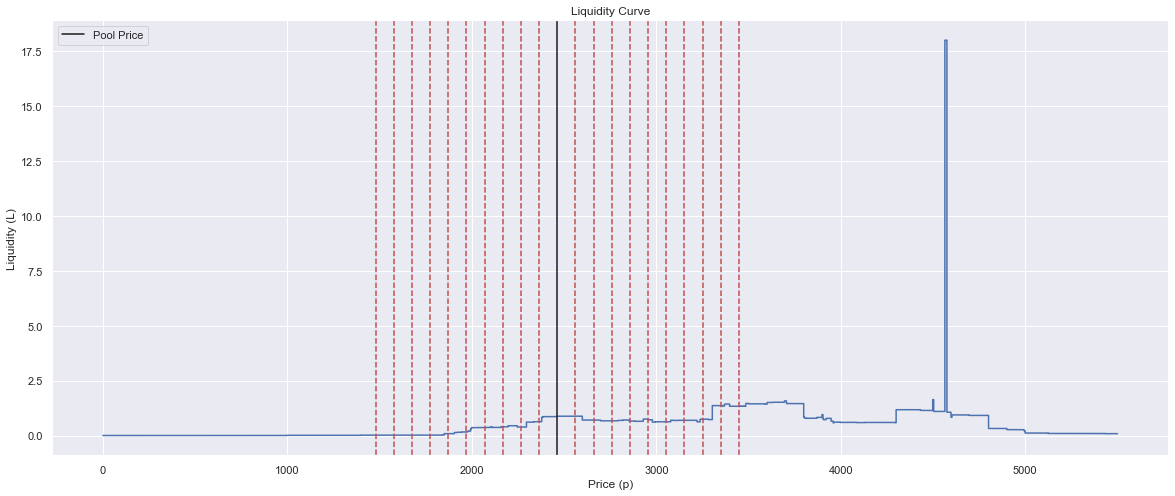

In [13]:
example_day = '2022-01-27 00:00:00'
sigma = 0.04
pool = pool_snapshots[example_day]
price_bins = np.array(
    [0]
    + [pool.price * (1 + i * sigma) for i in range(-10, 11)]
    + [np.inf]
)

fig, ax = plt.subplots(figsize=(20, 8))
pool.plot_liquidity_curve(interval=(0, 5000), ax=ax)

for price in price_bins[1:-1]:
    if price == pool.price:
        ax.axvline(price, color='k', label='Pool Price')
    else:
        ax.axvline(price, color='r', linestyle='--')
ax.legend(loc='upper left')

plt.show()

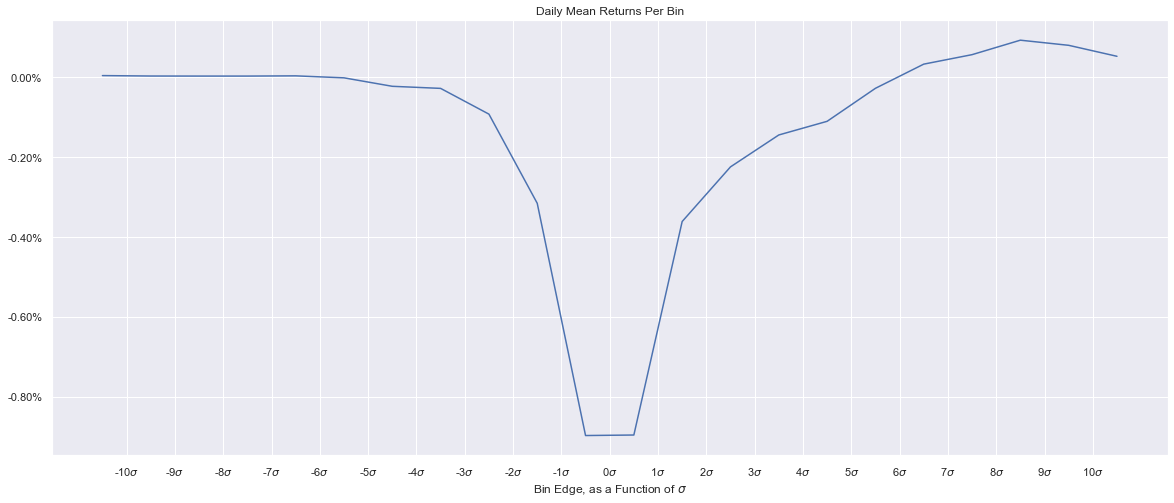

CPU times: user 3min 58s, sys: 8.04 s, total: 4min 6s
Wall time: 4min 7s


In [14]:
%%time
# daily returns
all_returns = calc_all_returns_per_bin(
    pool_snapshots, 
    all_txn, 
    liquidity, 
    swaps,
    freq='D',  # pandas frequency codes (can also include anchor)
    sigma=0.04, 
    numeraire_token=NUMERAIRE_TOKEN
)
pd.to_pickle(all_returns, SAVED_DAILY_RETURNS)
   
bin_returns = defaultdict(list)
for day, irrs in all_returns.items():
    for bin_pos, irr in irrs.items():
        bin_no = int(re.findall(r'_bin(\d+)_', bin_pos)[0])
        bin_returns[bin_no].append(irr)
        
fig, ax = plt.subplots(figsize=(20, 8))

x_pos, x_labels, y = [], [], []
for i in range(1, 23):
    x_pos.append(i)
    x_labels.append(f'{i - 11}$\sigma$')
    y.append(np.mean(bin_returns[i]))
ax.plot(x_pos, y)

ax.set_xticks(ticks=np.array(x_pos[:-1]) + 0.5, labels=x_labels[:-1])
ax.set_title('Daily Mean Returns Per Bin')
ax.set_xlabel('Bin Edge, as a Function of $\sigma$')
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.2%}'))

plt.show()

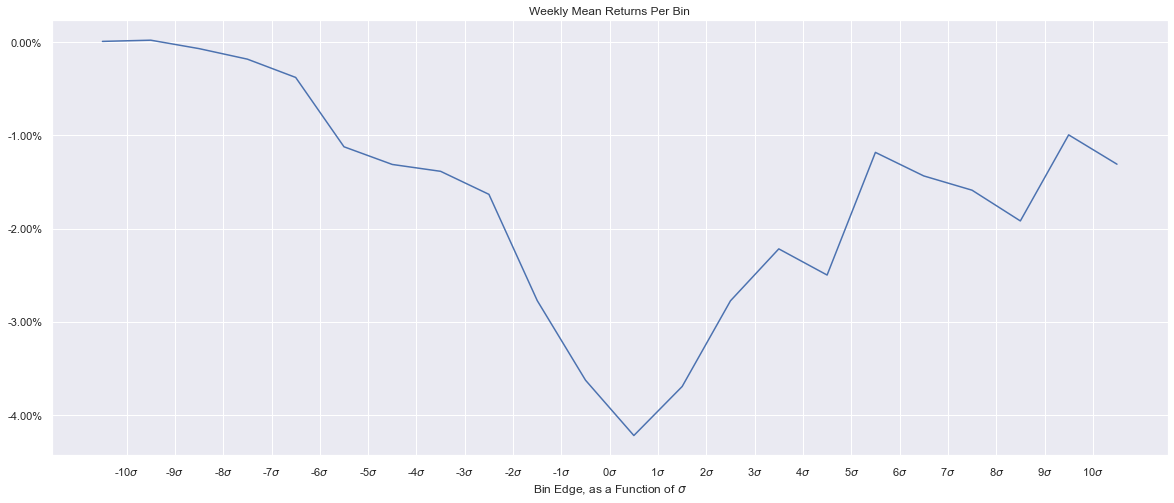

CPU times: user 2min 54s, sys: 8.12 s, total: 3min 2s
Wall time: 3min 4s


In [15]:
%%time
# weekly returns
all_returns = calc_all_returns_per_bin(
    pool_snapshots, 
    all_txn, 
    liquidity, 
    swaps,
    freq='W',  # pandas frequency codes (can also include anchor)
    sigma=0.04, 
    numeraire_token=NUMERAIRE_TOKEN
)
pd.to_pickle(all_returns, SAVED_WEEKLY_RETURNS)
   
bin_returns = defaultdict(list)
for day, irrs in all_returns.items():
    for bin_pos, irr in irrs.items():
        bin_no = int(re.findall(r'_bin(\d+)_', bin_pos)[0])
        bin_returns[bin_no].append(irr)
        
fig, ax = plt.subplots(figsize=(20, 8))

x_pos, x_labels, y = [], [], []
for i in range(1, 23):
    x_pos.append(i)
    x_labels.append(f'{i - 11}$\sigma$')
    y.append(np.mean(bin_returns[i]))
ax.plot(x_pos, y)

ax.set_xticks(ticks=np.array(x_pos[:-1]) + 0.5, labels=x_labels[:-1])
ax.set_title('Weekly Mean Returns Per Bin')
ax.set_xlabel('Bin Edge, as a Function of $\sigma$')
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.2%}'))

plt.show()

In [16]:
# %%time
# # hourly returns
# all_returns = calc_all_returns_per_bin(
#     pool_snapshots, 
#     all_txn, 
#     liquidity, 
#     swaps,
#     freq='H',  # pandas frequency codes (can also include anchor)
#     sigma=0.005,  # reducing this for this test
#     numeraire_token=NUMERAIRE_TOKEN
# )
# # pd.to_pickle(all_returns, SAVED_WEEKLY_RETURNS) NOT SAVING THIS ONE FOR NOW!
   
# bin_returns = defaultdict(list)
# for day, irrs in all_returns.items():
#     for bin_pos, irr in irrs.items():
#         bin_no = int(re.findall(r'_bin(\d+)_', bin_pos)[0])
#         bin_returns[bin_no].append(irr)
        
# fig, ax = plt.subplots(figsize=(20, 8))

# x_pos, x_labels, y = [], [], []
# for i in range(1, 23):
#     x_pos.append(i)
#     x_labels.append(f'{i - 11}$\sigma$')
#     y.append(np.mean(bin_returns[i]))
# ax.plot(x_pos, y)

# ax.set_xticks(ticks=np.array(x_pos[:-1]) + 0.5, labels=x_labels[:-1])
# ax.set_title('Hourly Mean Returns Per Bin')
# ax.set_xlabel('Bin Edge, as a Function of $\sigma$')
# ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.2%}'))

# plt.show()